In [67]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt
#import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
config = get_config()
good_scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
            *config.model_parameters)
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        good_scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
bad_scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
            *config.model_parameters)
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and ("EE" not in file and "Trk" not in file):
        print(file)
        entered = True
        bad_scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
good_scoreModel.eval()
bad_scoreModel.eval()
""

trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtfQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp33
trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtfQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_NEp35


''

In [82]:
data = np.load(config.data_path, allow_pickle=True)
size = 10000
pathidx=np.random.randint(low=0, high=data.shape[0], size=size)
timeidx=np.random.randint(low=0, high=data.shape[1], size=size)
inc = data[pathidx, timeidx] - data[pathidx, timeidx - 1]
data = data[pathidx, timeidx-1]
idxs = np.argwhere(np.abs(data)<1.)
times = torch.Tensor([1]*data.shape[0])
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
eff_times = diffusion.get_eff_times(times)
sample = {
     "inputs":torch.Tensor([inc]).reshape(size, 1, 1),
     "times":      times,
     "conditioner": torch.Tensor([data]).reshape(size,1,1),
     "eff_times":   torch.Tensor(eff_times).reshape(size, 1, 1),
 }


[[   0]
 [   1]
 [   2]
 ...
 [9997]
 [9998]
 [9999]]


(array([  12.,   82.,  439., 1541., 3391., 2908., 1241.,  318.,   64.,
           4.]),
 array([-2.25355983, -1.79183066, -1.33010149, -0.86837238, -0.40664324,
         0.0550859 ,  0.51681507,  0.97854418,  1.44027328,  1.90200245,
         2.36373162]),
 <BarContainer object of 10 artists>)

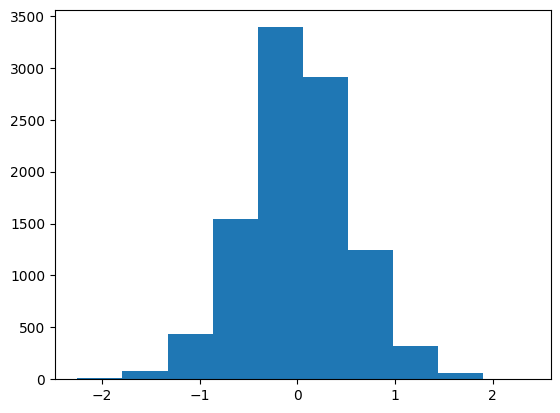

In [81]:
plt.hist(sample["conditioner"].flatten())

In [72]:
# ============================================================
# Good vs Bad checkpoint comparison (non-mutating, shape-safe)
# Expects:
#   good_scoreModel  # "before spike"   (already loaded)
#   bad_scoreModel   # "after spike"    (already loaded)
#
# You provide one sample dict with the SAME preprocessing you use at eval:
# sample = {
#   "inputs":      Tensor [B,1,D] or [B,D] or [D],
#   "times":       Tensor [B] or scalar,
#   "conditioner": Tensor [B,1,D] or [B,D] or [D],
#   "eff_times":   Tensor [B,1,1] or [B] or scalar,
# }
#
# What this reports:
#   1) Weight deltas + cosine similarity
#   2) Spectral growth (top singular values) per layer
#   3) Activation RMSE per key module (same input)
#   4) Output drift (MSE/MAE) and surrogate loss change (same input)
#   5) Per-eff_times-bin output drift (localizes regime)
#   6) Input-gradient norm (optional) to detect curvature/exploding sensitivity
# ============================================================

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# Shape handling (no padding/trim)
# ------------------------------
def _to_dev_dtype(x, ref_param):
    if x.dtype.is_floating_point:
        return x.to(ref_param.device, ref_param.dtype)
    else:
        return x.to(ref_param.device)

def standardize_sample(sample: dict, model: nn.Module) -> dict:
    p = next(model.parameters())

    # inputs -> [B,1,D]
    x = _to_dev_dtype(sample["inputs"], p)
    if x.ndim == 1:            # [D]
        x = x.unsqueeze(0).unsqueeze(0)               # [1,1,D]
    elif x.ndim == 2:          # [B,D]
        x = x.unsqueeze(1)                             # [B,1,D]
    elif x.ndim == 3:
        assert x.size(1) == 1, "inputs second dim must be 1"
    else:
        raise RuntimeError(f"inputs bad shape {tuple(x.shape)}")

    B = x.size(0)

    # conditioner -> [B,1,D] (match B; keep D as-is)
    c = _to_dev_dtype(sample["conditioner"], p)
    if c.ndim == 1:            # [D]
        c = c.unsqueeze(0).unsqueeze(1)               # [1,1,D]
    elif c.ndim == 2:          # [B,D]
        c = c.unsqueeze(1)                             # [B,1,D]
    elif c.ndim == 3:
        assert c.size(1) == 1, "conditioner second dim must be 1"
    else:
        raise RuntimeError(f"conditioner bad shape {tuple(c.shape)}")
    if c.size(0) == 1 and B > 1:
        c = c.expand(B, -1, -1)
    assert c.size(-1) == x.size(-1), f"D mismatch: inputs D={x.size(-1)} vs cond D={c.size(-1)}"

    # times -> [B]
    t = sample["times"].to(p.device).view(-1)
    if t.numel() == 1: t = t.expand(B)

    # eff_times -> [B,1,1]
    et = _to_dev_dtype(sample["eff_times"], p).view(-1)
    if et.numel() == 1: et = et.expand(B)
    et = et.view(B, 1, 1)

    return {"inputs": x, "times": t, "conditioner": c, "eff_times": et}

# ------------------------------
# Non-mutating hook helpers
# ------------------------------
def clear_all_hooks(model: nn.Module) -> None:
    for m in model.modules():
        m._forward_hooks.clear()
        m._forward_pre_hooks.clear()
        m._backward_hooks.clear()

# ------------------------------
# Reports: weights and spectra
# ------------------------------
def flat_vec(model: nn.Module, device="cpu", dtype=torch.float64) -> torch.Tensor:
    parts = [p.detach().to(device=device, dtype=dtype).flatten()
             for p in model.parameters() if p.requires_grad]
    return torch.cat(parts) if parts else torch.tensor([], dtype=dtype, device=device)

def weight_diff_report(model0: nn.Module, model1: nn.Module, top=25) -> None:
    pb = dict(model1.named_parameters())
    rows, tot_sq = [], 0.0
    for n, pa in model0.named_parameters():
        if not pa.requires_grad or n not in pb: continue
        d = (pb[n].detach() - pa.detach()).flatten()
        dn = d.norm().item()
        wn = pa.detach().flatten().norm().item()
        rows.append((n, dn, dn/(wn+1e-12)))
        tot_sq += dn*dn
    rows.sort(key=lambda x: x[1], reverse=True)
    v0 = flat_vec(model0); v1 = flat_vec(model1)
    cos = F.cosine_similarity(v0.unsqueeze(0), v1.unsqueeze(0), dim=1).item() if v0.numel() and v1.numel() else float("nan")
    print(f"||Δθ|| = {math.sqrt(tot_sq):.6g}")
    print(f"cosine(flat_weights_pre, flat_weights_post) = {cos:.6f}")
    for n, d, r in rows[:top]:
        print(f"{n:45s}  |Δ|={d:.5g}   rel={r:.3e}")

@torch.no_grad()
def _top_singular_value(W: torch.Tensor, iters=15) -> float:
    if W.ndim < 2: return float("nan")
    M = W.reshape(W.size(0), -1)
    u = F.normalize(torch.randn(M.size(0), device=M.device), dim=0)
    for _ in range(iters):
        v = F.normalize(M.t().mv(u), dim=0)
        u = F.normalize(M.mv(v), dim=0)
    return u.dot(M.mv(v)).abs().item()

def spectral_report(model0: nn.Module, model1: nn.Module, top=12) -> None:
    pb = dict(model1.named_parameters())
    rows = []
    for n, p0 in model0.named_parameters():
        if n not in pb or p0.ndim < 2: continue
        s0 = _top_singular_value(p0.detach())
        s1 = _top_singular_value(pb[n].detach())
        rows.append((n, s0, s1, s1/(s0+1e-12)))
    rows.sort(key=lambda x: x[3], reverse=True)
    for n, s0, s1, r in rows[:top]:
        print(f"{n:45s}  s_max: {s0:.5g} → {s1:.5g}   ×{r:.3f}")

# ------------------------------
# Activation diffs (same input)
# ------------------------------
def list_capture_modules(model: nn.Module) -> list[str]:
    names = []
    for name, mod in model.named_modules():
        if isinstance(mod, (nn.Conv1d, nn.Linear)):
            names.append(name)
    # Deduplicate and keep stable order
    seen, out = set(), []
    for n in names:
        if n not in seen:
            out.append(n); seen.add(n)
    return out

@torch.no_grad()
def capture_activations(model: nn.Module, sample: dict, names: list[str]) -> dict[str, torch.Tensor]:
    bufs = {}
    hs = []
    for name, mod in model.named_modules():
        if name in names:
            def make_hook(nm):
                def _h(m, inp, out):
                    if isinstance(out, (tuple, list)):
                        out = out[0]
                    bufs[nm] = out.detach().float().flatten()
                return _h
            hs.append(mod.register_forward_hook(make_hook(name)))
    s = standardize_sample(sample, model)
    _ = model(s["inputs"], s["times"], s["conditioner"], s["eff_times"])
    for h in hs: h.remove()
    return bufs

def activation_diff_report(good: nn.Module, bad: nn.Module, sample: dict, top=25) -> None:
    names = list_capture_modules(good)
    a0 = capture_activations(good, sample, names)
    a1 = capture_activations(bad,  sample, names)
    rows = []
    for k in names:
        if k in a0 and k in a1:
            d = (a1[k] - a0[k])
            rmse = d.pow(2).mean().sqrt().item()
            rows.append((k, rmse, a0[k].numel()))
    rows.sort(key=lambda x: x[1], reverse=True)
    print(f"Activation RMSE per module (same input), top {min(top,len(rows))}:")
    for k, r, n in rows[:top]:
        print(f"{k:45s}  RMSE={r:.6g}   n={n}")

# ------------------------------
# Output drift + loss change
# ------------------------------
@torch.no_grad()
def output_and_loss(model: nn.Module, sample: dict, loss_fn=None):
    s = standardize_sample(sample, model)
    y = model(s["inputs"], s["times"], s["conditioner"], s["eff_times"])
    beta_tau = torch.exp(-0.5 * s["eff_times"])
    sigma2_tau = (1. - torch.exp(-s["eff_times"]))
    # Network tries to learn the posterior mean
    y = (y + s["inputs"] / sigma2_tau) * (sigma2_tau / beta_tau)  # This gives us the network D_theta
    if loss_fn is None:
        loss = F.mse_loss(y, s["inputs"])
    else:
        loss = loss_fn(y, s["inputs"])
    return y, loss.item()

@torch.no_grad()
def output_drift_and_loss_change(good: nn.Module, bad: nn.Module, sample: dict, loss_fn=None):
    y0, l0 = output_and_loss(good, sample, loss_fn)
    y1, l1 = output_and_loss(bad,  sample, loss_fn)
    mse = F.mse_loss(y1, y0).item()
    mae = (y1 - y0).abs().mean().item()
    print(f"Output drift: MSE={mse:.6g}  MAE={mae:.6g}")
    print(f"Surrogate loss: pre={l0:.6g}  post={l1:.6g}")

# ------------------------------
# Per-eff_times-bin drift
# ------------------------------
@torch.no_grad()
def drift_by_tbin(good: nn.Module, bad: nn.Module, sample: dict, nbins=6):
    sg = standardize_sample(sample, good)
    sb = standardize_sample(sample, bad)
    et = sg["eff_times"].view(sg["eff_times"].size(0))  # [B]
    q = torch.quantile(et, torch.linspace(0,1,nbins+1, device=et.device))
    q[0] -= 1e-6; q[-1] += 1e-6
    vals = []
    for i in range(nbins):
        m = (et >= q[i]) & (et < q[i+1])
        if m.any():
            y0 = good(sg["inputs"][m], sg["times"][m], sg["conditioner"][m], sg["eff_times"][m])
            y1 = bad (sb["inputs"][m], sb["times"][m], sb["conditioner"][m], sb["eff_times"][m])
            vals.append(F.mse_loss(y1, y0).item())
        else:
            vals.append(float('nan'))
    print("Per-eff_times-bin output MSE:", [None if math.isnan(v) else float(f"{v:.4g}") for v in vals])

# ------------------------------
# Input gradient norm (optional)
# ------------------------------
def input_grad_norm(model: nn.Module, sample: dict, loss_fn=None):
    s = standardize_sample(sample, model)
    x = s["inputs"].detach().clone().requires_grad_(True)
    y = model(x, s["times"], s["conditioner"], s["eff_times"])
    beta_tau = torch.exp(-0.5 * s["eff_times"])
    sigma2_tau = (1. - torch.exp(-s["eff_times"]))
    # Network tries to learn the posterior mean
    y = (y + s["inputs"] / sigma2_tau) * (sigma2_tau / beta_tau)  # This gives us the network D_theta
    if loss_fn is None:
        loss = F.mse_loss(y, x)
    else:
        loss = loss_fn(y, x)
    loss.backward()
    g = x.grad.detach().flatten(1).norm(dim=1)  # [B]
    return g.mean().item(), g.median().item(), g.max().item()

# ------------------------------
# Entry point
# ------------------------------
def compare_models(good_scoreModel: nn.Module, bad_scoreModel: nn.Module, sample: dict, loss_fn=None):
    good_scoreModel.eval(); bad_scoreModel.eval()
    clear_all_hooks(good_scoreModel); clear_all_hooks(bad_scoreModel)

    print("\n[Weight delta report]")
    weight_diff_report(good_scoreModel, bad_scoreModel, top=300)

    print("\n[Spectral growth report]")
    spectral_report(good_scoreModel, bad_scoreModel, top=300)

    print("\n[Activation RMSE report]")
    activation_diff_report(good_scoreModel, bad_scoreModel, sample, top=300)

    print("\n[Output drift + loss change]")
    output_drift_and_loss_change(good_scoreModel, bad_scoreModel, sample, loss_fn=loss_fn)

    print("\n[Per-eff_times-bin output drift]")
    drift_by_tbin(good_scoreModel, bad_scoreModel, sample, nbins=6)

    print("\n[Input gradient norm (optional)]")
    m, med, mx = input_grad_norm(good_scoreModel, sample, loss_fn=loss_fn)
    print(f"good   input-grad: mean={m:.6g}  median={med:.6g}  max={mx:.6g}")
    m, med, mx = input_grad_norm(bad_scoreModel, sample, loss_fn=loss_fn)
    print(f"bad    input-grad: mean={m:.6g}  median={med:.6g}  max={mx:.6g}")

# ------------------------------
# Usage:
# ------------------------------
# sample = {
#     "inputs":      torch.randn(2,1,1),   # D=1 throughout
#     "times":       torch.tensor([1.0, 1.0]),
#     "conditioner": torch.randn(2,1,1),
#     "eff_times":   torch.tensor([10.0, 10.0]),
# }
compare_models(good_scoreModel, bad_scoreModel, sample, loss_fn=None)



[Weight delta report]
||Δθ|| = 0.0943961
cosine(flat_weights_pre, flat_weights_post) = 0.999996
diffusion_embedding.projection1.weight         |Δ|=0.058873   rel=1.199e-02
diffusion_embedding.projection2.weight         |Δ|=0.041878   rel=8.595e-03
residual_layers.7.diffusion_projection.weight  |Δ|=0.018334   rel=1.082e-02
residual_layers.4.diffusion_projection.weight  |Δ|=0.018076   rel=1.056e-02
residual_layers.3.diffusion_projection.weight  |Δ|=0.017194   rel=1.012e-02
residual_layers.8.diffusion_projection.weight  |Δ|=0.016889   rel=9.693e-03
residual_layers.6.diffusion_projection.weight  |Δ|=0.016458   rel=9.741e-03
residual_layers.0.diffusion_projection.weight  |Δ|=0.015804   rel=9.523e-03
residual_layers.2.diffusion_projection.weight  |Δ|=0.015001   rel=8.796e-03
residual_layers.9.diffusion_projection.weight  |Δ|=0.014738   rel=8.809e-03
residual_layers.5.diffusion_projection.weight  |Δ|=0.013909   rel=8.154e-03
residual_layers.1.diffusion_projection.weight  |Δ|=0.013719   rel=7